# Pitch Speed Prediction - Open Biomechanics Project

## By: Mojisoluwa (Jiso) Awe

This notebook explores the use of machine learning to predict pitch velocity based on kinematic and kinetic variables. The dataset is sourced from Driveline’s Open Biomechanics Project.

Key steps in this project include:

- Exploratory Data Analysis (EDA): Understanding trends and correlations within the data.
- Feature Engineering: Creating meaningful features to enhance model performance.
- Model Selection: Comparing various machine learning algorithms.
- Hyperparameter Tuning: Fine-tuning models for optimal accuracy.
- Feature Importance Analysis: Examining which kinematic and kinetic metrics contribute most to pitch velocity.
  
We conclude by analyzing the two best-performing models and their respective feature importances, providing insights into how specific biomechanical variables affect pitch velocity.


If you have any suggestions or questions, please reach out to me via LinkedIn or email.

In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import shap
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from xgboost import XGBRegressor, plot_importance
from matplotlib.pyplot import figure

In [2]:
biomech = pd.read_csv("pitching_poi_metrics.csv")
metadata = pd.read_csv("pitching_metadata.csv")

In [3]:
biomech.head()

,session_pitch,session,p_throws,pitch_type,pitch_speed_mph,max_shoulder_internal_rotational_velo,max_elbow_extension_velo,max_torso_rotational_velo,max_rotation_hip_shoulder_separation,max_elbow_flexion,...,rear_grf_z_max,rear_grf_mag_max,rear_grf_angle_at_max,lead_grf_x_max,lead_grf_y_max,lead_grf_z_max,lead_grf_mag_max,lead_grf_angle_at_max,peak_rfd_rear,peak_rfd_lead
0,1031_2,1031,R,FF,90.4,4533.2480,2445.8177,958.0878,32.3152,109.9971,...,1497.9859,1736.0368,55.7071,1278.4966,270.7849,2484.8747,2782.9580,63.3501,11.6564,170.4620
1,1031_3,1031,R,FF,90.4,4571.1735,2389.5438,969.5766,32.5547,109.1065,...,1502.8258,1728.0176,60.2863,1436.1255,252.1999,2690.7521,3038.8913,62.3087,9.5715,183.6636
2,1097_1,1097,R,FF,77.6,4165.3055,2426.3029,1090.2269,33.1477,123.4752,...,1094.7686,1283.0751,58.3164,957.3923,245.4411,1767.4604,2010.5341,61.5594,4.4432,52.9333
3,1097_2,1097,R,FF,77.0,3832.1715,2424.0493,1105.2275,27.9286,124.6578,...,1187.5810,1354.7150,58.7397,860.3796,280.5177,1715.1864,1864.0488,66.6789,6.4897,54.3727
4,1097_3,1097,R,FF,76.1,3970.7971,2497.6253,1110.4850,28.9909,124.8308,...,1214.0065,1425.2124,58.0297,1066.6047,337.4227,2120.4510,2283.1749,65.9014,7.2019,106.2719


In [4]:
metadata.head()

,user,session,session_pitch,session_mass_kg,session_height_m,age_yrs,playing_level,pitch_speed_mph,filename_new,modelname_new
0,750,1031,1031_2,110.6784,1.9304,21.40,college,90.4,000750_001031_76_244_013_FF_904.c3d,000750_001031_model.c3d
1,750,1031,1031_3,110.6784,1.9304,21.40,college,90.4,000750_001031_76_244_014_FF_904.c3d,000750_001031_model.c3d
2,774,1097,1097_1,101.1528,1.9304,19.41,college,77.6,000774_001097_76_223_001_FF_776.c3d,000774_001097_model.c3d
3,774,1097,1097_2,101.1528,1.9304,19.41,college,77.0,000774_001097_76_223_005_FF_770.c3d,000774_001097_model.c3d
4,774,1097,1097_3,101.1528,1.9304,19.41,college,76.1,000774_001097_76_223_006_FF_761.c3d,000774_001097_model.c3d


In [5]:
biomech.shape

(411, 81)

In [6]:
metadata.shape

(411, 10)

In [7]:
# They have the same amount of rows, they can easily be joined
merged_data = pd.merge(metadata, biomech, on = ['session_pitch', 'session', 'pitch_speed_mph'])
merged_data.shape

(411, 88)

In [8]:
merged_data.head()

,user,session,session_pitch,session_mass_kg,session_height_m,age_yrs,playing_level,pitch_speed_mph,filename_new,modelname_new,...,rear_grf_z_max,rear_grf_mag_max,rear_grf_angle_at_max,lead_grf_x_max,lead_grf_y_max,lead_grf_z_max,lead_grf_mag_max,lead_grf_angle_at_max,peak_rfd_rear,peak_rfd_lead
0,750,1031,1031_2,110.6784,1.9304,21.40,college,90.4,000750_001031_76_244_013_FF_904.c3d,000750_001031_model.c3d,...,1497.9859,1736.0368,55.7071,1278.4966,270.7849,2484.8747,2782.9580,63.3501,11.6564,170.4620
1,750,1031,1031_3,110.6784,1.9304,21.40,college,90.4,000750_001031_76_244_014_FF_904.c3d,000750_001031_model.c3d,...,1502.8258,1728.0176,60.2863,1436.1255,252.1999,2690.7521,3038.8913,62.3087,9.5715,183.6636
2,774,1097,1097_1,101.1528,1.9304,19.41,college,77.6,000774_001097_76_223_001_FF_776.c3d,000774_001097_model.c3d,...,1094.7686,1283.0751,58.3164,957.3923,245.4411,1767.4604,2010.5341,61.5594,4.4432,52.9333
3,774,1097,1097_2,101.1528,1.9304,19.41,college,77.0,000774_001097_76_223_005_FF_770.c3d,000774_001097_model.c3d,...,1187.5810,1354.7150,58.7397,860.3796,280.5177,1715.1864,1864.0488,66.6789,6.4897,54.3727
4,774,1097,1097_3,101.1528,1.9304,19.41,college,76.1,000774_001097_76_223_006_FF_761.c3d,000774_001097_model.c3d,...,1214.0065,1425.2124,58.0297,1066.6047,337.4227,2120.4510,2283.1749,65.9014,7.2019,106.2719


In [41]:
#list(merged_data.columns)

In [10]:
merged_data.isnull().sum().max()

8

In [11]:
merged_data = merged_data.dropna()

In [12]:
merged_data.isna().sum().max()

0

# Exploratory Data Analysis

In [13]:
print(merged_data['pitch_speed_mph'].describe())

count    403.000000
mean      84.777667
std        4.694036
min       69.500000
25%       81.450000
50%       85.400000
75%       87.900000
max       94.400000
Name: pitch_speed_mph, dtype: float64


Here we can see that after data cleaning we have 411 pitches in the dataset, with an average velocity of 84.7 mph and a median velocity of 85.3 mph. Next I'll be visualizing the distribution of the data, so we can have a better idea of the range of the ball velocities.

<Figure size 900x800 with 0 Axes>

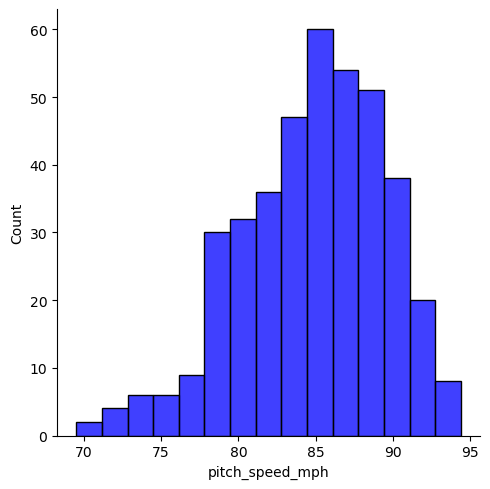

In [14]:
plt.figure(figsize=(9, 8))
sns.displot(merged_data['pitch_speed_mph'], color = 'b')
plt.show()

After visualizing the data we can see that the greater majority of the velocities lie between 80 and 90 mph. The data has a slight right-skew due to there being a number of pitches within the 70-75 mph range and fewer pitches in that 90-95 mph range.

# One Hot Encoding

In [15]:
## all the pitches are FB so dropping, this information from the data
merged_data['pitch_type'].unique()

array(['FF'], dtype=object)

In [16]:
cat = merged_data.select_dtypes(include = ['object', 'category'])
print(cat.columns)

Index(['session_pitch', 'playing_level', 'filename_new', 'modelname_new',
       'p_throws', 'pitch_type'],
      dtype='object')


In [17]:
merged_data = merged_data.drop(columns = ['user', 'session','session_pitch','filename_new', 'modelname_new', 'pitch_type'])

In [18]:
encoded_data = pd.get_dummies(merged_data)

In [19]:
encoded_data.head()

,session_mass_kg,session_height_m,age_yrs,pitch_speed_mph,max_shoulder_internal_rotational_velo,max_elbow_extension_velo,max_torso_rotational_velo,max_rotation_hip_shoulder_separation,max_elbow_flexion,max_shoulder_external_rotation,...,lead_grf_mag_max,lead_grf_angle_at_max,peak_rfd_rear,peak_rfd_lead,playing_level_college,playing_level_high_school,playing_level_independent,playing_level_milb,p_throws_L,p_throws_R
0,110.6784,1.9304,21.40,90.4,4533.2480,2445.8177,958.0878,32.3152,109.9971,162.3480,...,2782.9580,63.3501,11.6564,170.4620,True,False,False,False,False,True
1,110.6784,1.9304,21.40,90.4,4571.1735,2389.5438,969.5766,32.5547,109.1065,162.8656,...,3038.8913,62.3087,9.5715,183.6636,True,False,False,False,False,True
2,101.1528,1.9304,19.41,77.6,4165.3055,2426.3029,1090.2269,33.1477,123.4752,158.8107,...,2010.5341,61.5594,4.4432,52.9333,True,False,False,False,False,True
3,101.1528,1.9304,19.41,77.0,3832.1715,2424.0493,1105.2275,27.9286,124.6578,155.2244,...,1864.0488,66.6789,6.4897,54.3727,True,False,False,False,False,True
4,101.1528,1.9304,19.41,76.1,3970.7971,2497.6253,1110.4850,28.9909,124.8308,156.2257,...,2283.1749,65.9014,7.2019,106.2719,True,False,False,False,False,True


In [20]:
y = encoded_data['pitch_speed_mph']
X = encoded_data.drop(['pitch_speed_mph'], axis = 1)

# Model Comparisions

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 123)

## Random Forest

In [22]:
model_RF = RandomForestRegressor()
model_RF.fit(X_train, y_train)
y_pred_RF = model_RF.predict(X_test)

## training
print("Train R-Squared Score:", r2_score(y_train, model_RF.predict(X_train)))
print("Train MAE Score:", mean_absolute_error(y_train, model_RF.predict(X_train)))
print("Train MSE Score:", mean_squared_error(y_train, model_RF.predict(X_train)))

## testing
print("Test R-Squared Score:", r2_score(y_test, y_pred_RF))
print("Test MAE Score:", mean_absolute_error(y_test, y_pred_RF))
print("Test MSE Score:", mean_squared_error(y_test, y_pred_RF))

Train R-Squared Score: 0.9747753910519321
Train MAE Score: 0.519744444444447
Train MSE Score: 0.519572899999998
Test R-Squared Score: 0.7905896570066695
Test MAE Score: 1.6351654135338327
Test MSE Score: 5.157709150375926


## SGD Regressor

In [23]:
model_SGD = SGDRegressor()
model_SGD.fit(X_train, y_train)
y_pred_sgd = model_SGD.predict(X_test)

## training
print("Train R-Squared Score:", r2_score(y_train, model_SGD.predict(X_train)))
print("Train MAE Score:", mean_absolute_error(y_train, model_SGD.predict(X_train)))
print("Train MSE Score:", mean_squared_error(y_train, model_SGD.predict(X_train)))

## testing
print("Test R-Squared Score:", r2_score(y_test, y_pred_sgd))
print("Test MAE Score:", mean_absolute_error(y_test, y_pred_sgd))
print("Test MSE Score:", mean_squared_error(y_test, y_pred_sgd))

Train R-Squared Score: -4.393213400952493e+34
Train MAE Score: 2.9684796882370784e+17
Train MSE Score: 9.04907834944486e+35
Test R-Squared Score: -2.0845784438050784e+34
Test MAE Score: 1.9415463617190656e+17
Test MSE Score: 5.134249417008161e+35


## Gradient Boosting Regressor

In [24]:
model_GBR = GradientBoostingRegressor()
model_GBR.fit(X_train, y_train)
y_pred_gbr = model_GBR.predict(X_test)

## training
print("Train R-Squared Score:", r2_score(y_train, model_GBR.predict(X_train)))
print("Train MAE Score:", mean_absolute_error(y_train, model_GBR.predict(X_train)))
print("Train MSE Score:", mean_squared_error(y_train, model_GBR.predict(X_train)))

## testing
print("Test R-Squared Score:", r2_score(y_test, y_pred_gbr))
print("Test MAE Score:", mean_absolute_error(y_test, y_pred_gbr))
print("Test MSE Score:", mean_squared_error(y_test, y_pred_gbr))

Train R-Squared Score: 0.9930711743918132
Train MAE Score: 0.29729821312318366
Train MSE Score: 0.14271896235345272
Test R-Squared Score: 0.8515464722163956
Test MAE Score: 1.3845857013998535
Test MSE Score: 3.656362468588619


## XGBoost

In [25]:
model_XGBR = XGBRegressor(n_estimators = 200, objective = 'reg:squarederror')
model_XGBR.fit(X_train, y_train)
y_pred_XGB = model_XGBR.predict(X_test)

## training
print("Train R-Squared Score:", r2_score(y_train, model_XGBR.predict(X_train)))
print("Train MAE Score:", mean_absolute_error(y_train, model_XGBR.predict(X_train)))
print("Train MSE Score:", mean_squared_error(y_train, model_XGBR.predict(X_train)))

## testing
print("Test R-Squared Score:", r2_score(y_test, y_pred_XGB))
print("Test MAE Score:", mean_absolute_error(y_test, y_pred_XGB))
print("Test MSE Score:", mean_squared_error(y_test, y_pred_XGB))

Train R-Squared Score: 0.9999999846776632
Train MAE Score: 0.0004296140317561763
Train MSE Score: 3.1560730982477486e-07
Test R-Squared Score: 0.7980423145223356
Test MAE Score: 1.441369296195812
Test MSE Score: 4.974152601479037


## XGBoost vs Gradient Boosting Regressor

After looking at model performance on both training and test dataset, I've narrowed it down to the XGBoost model and Gradient Boosting model. I'll be doing a comparison of the models before deciding and hyperparameter tuning the approriate one.

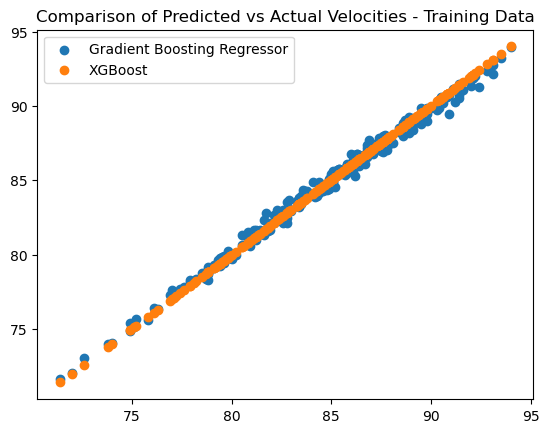

In [26]:
# Plotting comaparison of predicted velo vs actual
plt.figure()
plt.title('Comparison of Predicted vs Actual Velocities - Training Data')
plt.scatter(y_train, model_GBR.predict(X_train), label = "Gradient Boosting Regressor")
plt.scatter(y_train, model_XGBR.predict(X_train), label = "XGBoost")
plt.legend()

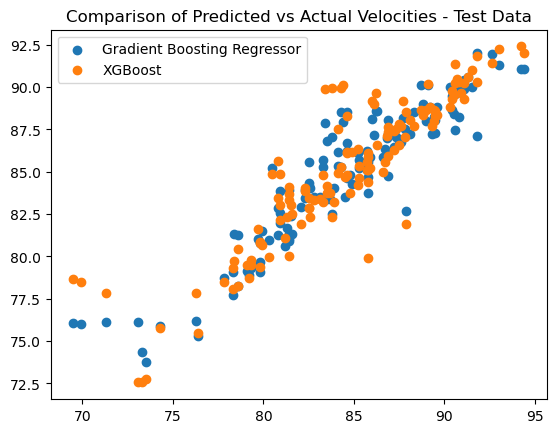

In [27]:
plt.figure()
plt.title('Comparison of Predicted vs Actual Velocities - Test Data')
plt.scatter(y_test, y_pred_gbr, label = "Gradient Boosting Regressor")
plt.scatter(y_test, y_pred_XGB, label = "XGBoost")
plt.legend()

When looking at side by side comparisons of both models performance on the training and test datasets, the XGBoost model has a more consistent performance. Yet, it's clear that both models struggle to accurately predict velocities for data points in the low 70s.

To get a better understanding of the spread of the distribution of the errors for both models I've visualized them below.

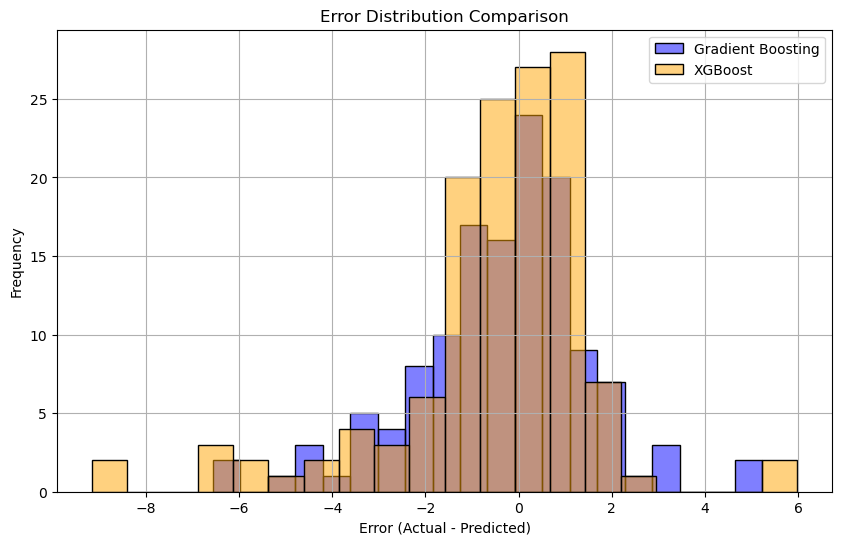

In [33]:
errors_gb = y_test - y_pred_gbr
errors_xgb = y_test - y_pred_XGB

plt.figure(figsize=(10, 6))

sns.histplot(errors_gb, bins = 20, label = 'Gradient Boosting', color = 'blue', alpha = 0.5)
sns.histplot(errors_xgb, bins = 20, label = 'XGBoost', color = 'orange', alpha = 0.5)

plt.title('Error Distribution Comparison')
plt.xlabel('Error (Actual - Predicted)')
plt.ylabel('Frequency')
plt.legend()
plt.grid()

plt.show()

# Feature Importance Analysis

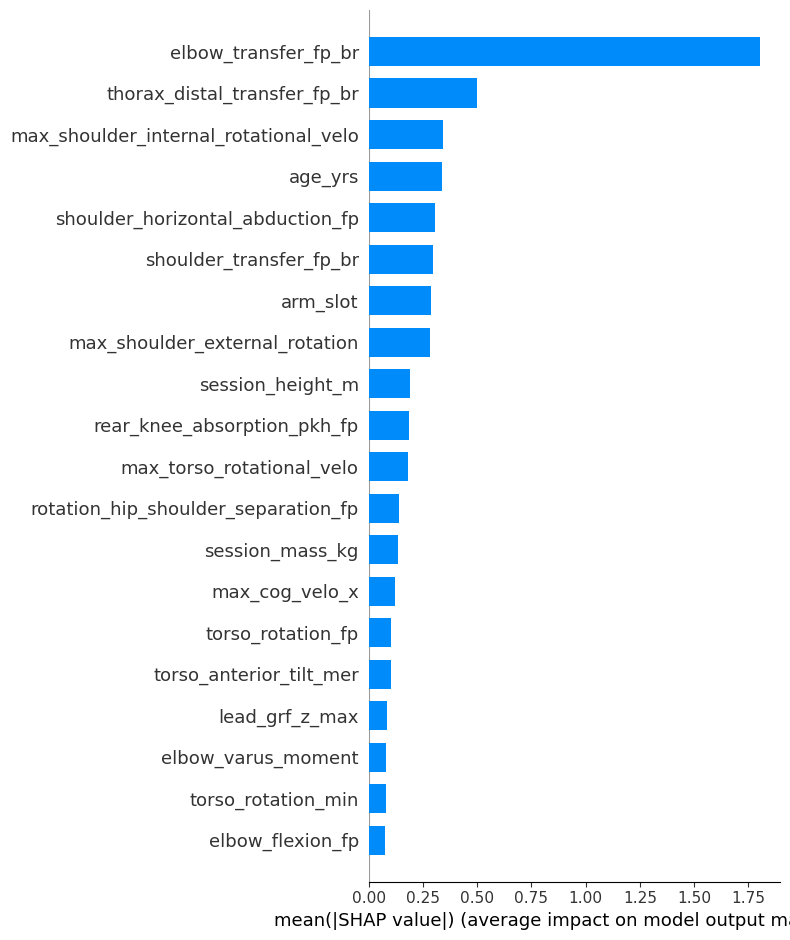

In [36]:
explainer = shap.Explainer(model_GBR)

shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, features = X, feature_names = X.columns, plot_type = 'bar')

When examining the feature importance of the Gradient Boosted model, we can see the model places importance on a select few features when it predicts pitch velocity. The features the Gradient Boosted Regressor placed the most importance on were elbow energy transfer, shoulder energy transfer, thorax distal energy transfer, shoulder internal rotation, and max shoulder internal rotational velocity. This model places high levels of importance on energy transfer levels in the body, which makes sense because if a pitcher is experiences a lot of energy leak, they won't be able to reach optimal pitch velocities. Here is a deep dive into some of these features and why I believe the model made them influential in determining pitch velocity.

### Elbow Energy Transfer
The measure of the energy transfer through the throwing elbow between foot plant and ball release was by far the most important feature to the GBR model. Most likely the model places importance on this because this metric highlights how effectively the pitcher is transferring kinetic energy from their lower body through their upper body onto the ball.

### Shoulder Energy Transfer
Shoulder energy transfer is another upper body metric that highlights effective movement within the throwing shoulder. The shoulder absorbs and redirects rotational energy from the trunk to the throwing arm. The model most likely is placing an emphasis on this metric because if someone has poor shoulder mechanics, they won't be able to properly impart energy onto the ball.

### Thorax Distal Energy
The thorax distal energy transfer measures how energy transfers out of the trunk to the distal part of the arm between foot plant and ball release. The thorax (chest) region is integral to the kinetic energy transfer that occurs in pitching. This energy transfer is crucial for maximizing arm speed. If energy transfer in this region of the body is inefficient, it can result in a loss of velocity.

### Shoulder Internal Rotation Moment
Torque is the rotational force that causes an object to rotate around a given axis. Shoulder internal rotation moment is the torque generated around the shoulder joint. As the pitcher nears ball release this movement allows the pitcher to transfer the energy generated in the lower body onto the ball.
The model likely prioritizes this metric because weaker internal rotation moment can cause lower pitch velocities. High internal rotation torque is crucial for maximizing pitch speed, as it translates to efficient energy transfer from the lower to the upper body.


In [317]:
X['elbow_transfer_fp_br'].describe()

count    403.00000
mean     342.59855
std       62.00829
min      195.92850
25%      297.87055
50%      337.59350
75%      390.00540
max      482.07030
Name: elbow_transfer_fp_br, dtype: float64

In [40]:
encoded_data['pitch_speed_mph'].corr(encoded_data['elbow_transfer_fp_br'])

0.6822101111323569

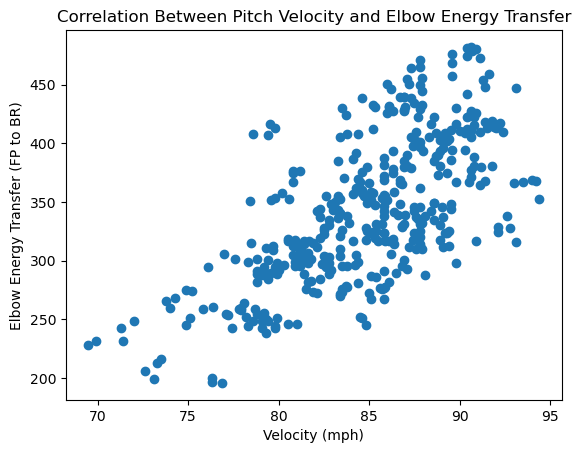

In [434]:
plt.scatter(encoded_data['pitch_speed_mph'], encoded_data['elbow_transfer_fp_br'])
plt.xlabel('Velocity (mph)')
plt.ylabel('Elbow Energy Transfer (FP to BR)')
plt.title('Correlation Between Pitch Velocity and Elbow Energy Transfer')
plt.show()

In [319]:
X['shoulder_transfer_fp_br'].describe()

count    403.000000
mean     339.106887
std       63.579396
min      170.608800
25%      295.212850
50%      330.724100
75%      386.140150
max      503.301700
Name: shoulder_transfer_fp_br, dtype: float64

In [38]:
encoded_data['pitch_speed_mph'].corr(encoded_data['shoulder_transfer_fp_br'])

0.6427005189791447

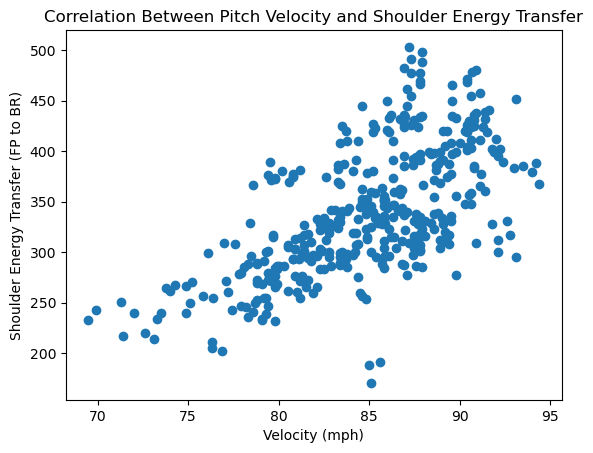

In [37]:
plt.scatter(encoded_data['pitch_speed_mph'], encoded_data['shoulder_transfer_fp_br'])
plt.xlabel('Velocity (mph)')
plt.ylabel('Shoulder Energy Transfer (FP to BR)')
plt.title('Correlation Between Pitch Velocity and Shoulder Energy Transfer')
plt.show()

In [323]:
X['thorax_distal_transfer_fp_br'].describe()

count    403.000000
mean     361.037755
std       64.343482
min      207.934900
25%      311.281600
50%      355.466600
75%      406.193400
max      536.950200
Name: thorax_distal_transfer_fp_br, dtype: float64

In [383]:
encoded_data['pitch_speed_mph'].corr(encoded_data['thorax_distal_transfer_fp_br'])

0.6360983827862416

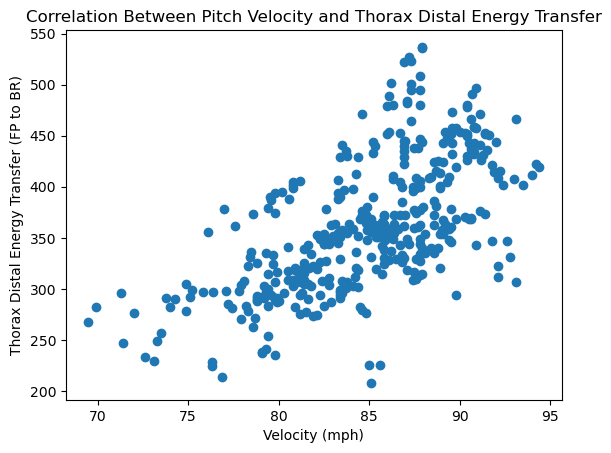

In [439]:
plt.scatter(encoded_data['pitch_speed_mph'], encoded_data['thorax_distal_transfer_fp_br'])
plt.xlabel('Velocity (mph)')
plt.ylabel('Thorax Distal Energy Transfer (FP to BR)')
plt.title('Correlation Between Pitch Velocity and Thorax Distal Energy Transfer')
plt.show()

In [321]:
X['shoulder_internal_rotation_moment'].describe()

count    403.000000
mean     106.499409
std       18.411728
min       63.243700
25%       92.929550
50%      107.898100
75%      116.903950
max      181.458600
Name: shoulder_internal_rotation_moment, dtype: float64

In [385]:
encoded_data['pitch_speed_mph'].corr(encoded_data['shoulder_internal_rotation_moment'])

0.5169249241809574

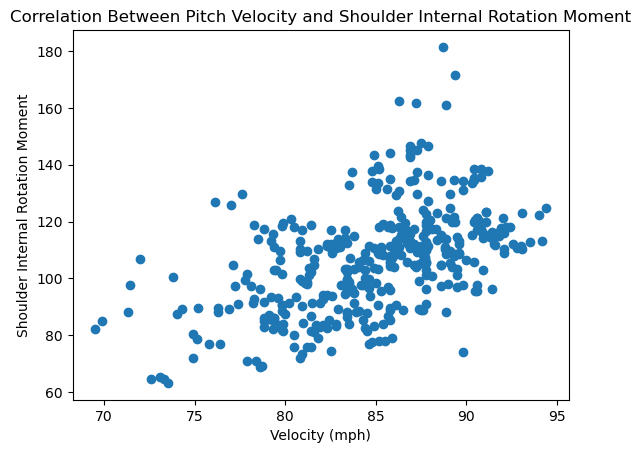

In [442]:
plt.scatter(encoded_data['pitch_speed_mph'], encoded_data['shoulder_internal_rotation_moment'])
plt.xlabel('Velocity (mph)')
plt.ylabel('Shoulder Internal Rotation Moment')
plt.title('Correlation Between Pitch Velocity and Shoulder Internal Rotation Moment')
plt.show()

### Variable Correlations

In [448]:
encoded_data['elbow_transfer_fp_br'].corr(encoded_data['shoulder_transfer_fp_br'])

0.9573902160187272

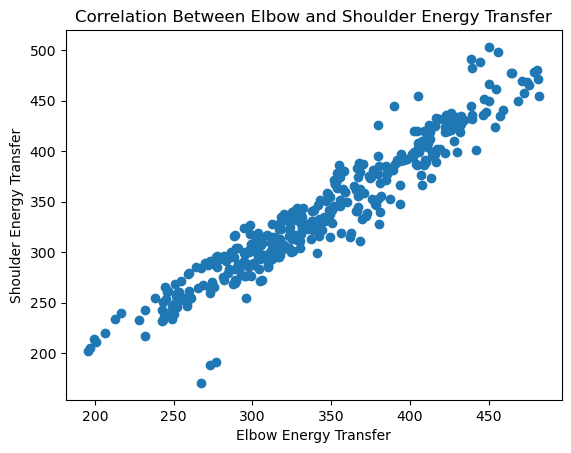

In [452]:
plt.scatter(encoded_data['elbow_transfer_fp_br'], encoded_data['shoulder_transfer_fp_br'])
plt.xlabel('Elbow Energy Transfer')
plt.ylabel('Shoulder Energy Transfer')
plt.title('Correlation Between Elbow and Shoulder Energy Transfer')
plt.show()

# XGBoost Feature Importance

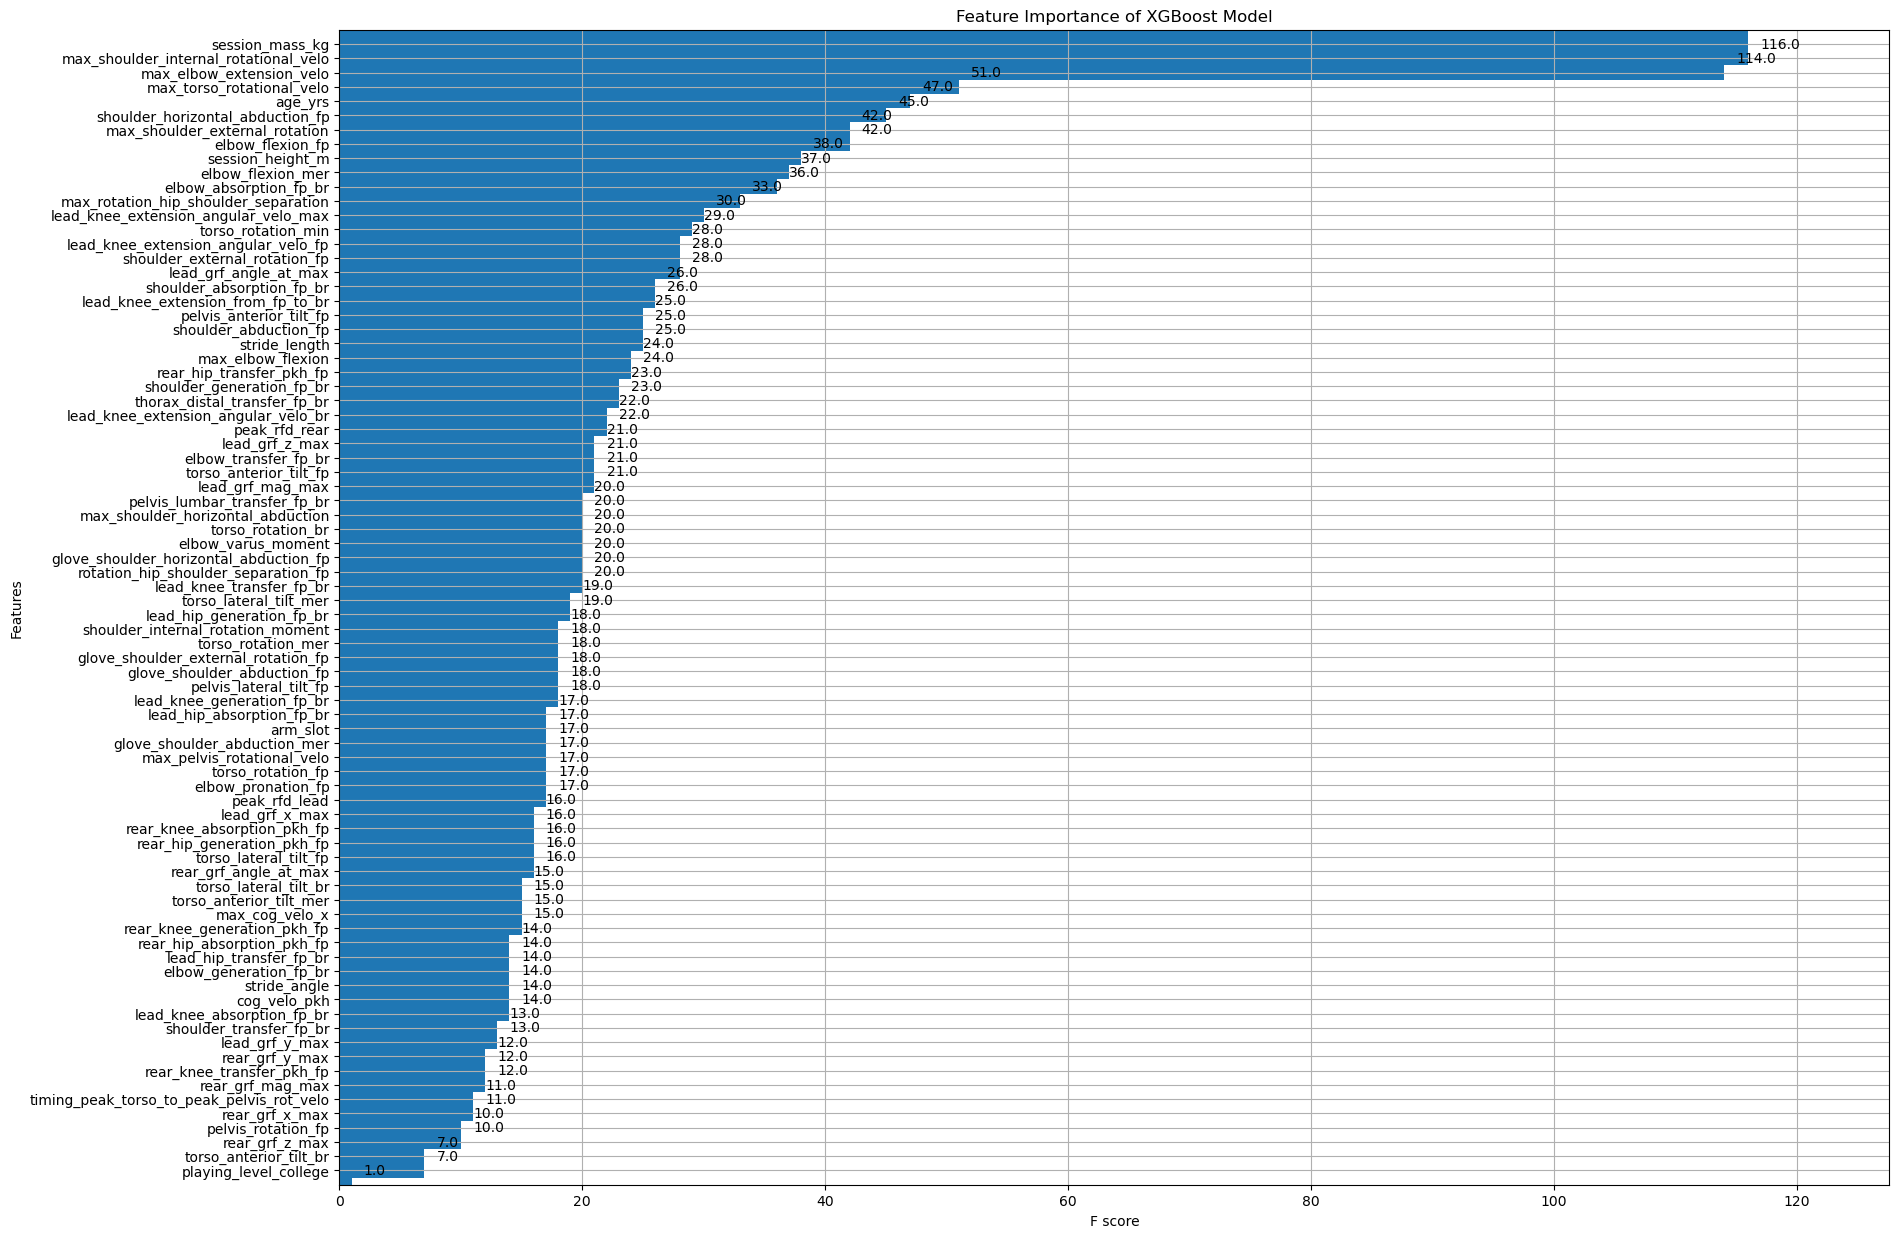

In [39]:
#XGBoost Feature Importance
fig, ax = plt.subplots(ncols = 1, figsize = (20,15))

plot_importance(model_XGBR, height = 3, ax = ax, title = 'Feature Importance of XGBoost Model')
plt.show()

The feature importance of the XGBoost model is a slightly more balanced than the Gradient Boosted model, but still places significant influence very few features. The most influence is on the pitchers mass (kg), maximum shoulder internal rotational velocity, followed by maximum elbow extension velocity and maximum torso rotational velocity, with less than half the amount of importance. Here I will explain what these metrics mean and why I believe the model places importance on them.

### Mass (kg)
When determining the ideal range for the ground reaction force (GRF), the pitcher should be generating the standard is 1.5x - 2x the pitchers body mass. GRF are an indictator of how well the pitcher is able to transfer the energy that is generated through their lower body. Generally higher GRF are correlated with higher pitching velocities. I believe that the reason the model is placing such a high level of importance on pitcher mass is because greater mass should produce higher GRF, which is correlated with velocity.

### Maximum Shoulder Internal Rotational Velocity
Internal shoulder rotation is the last movement the pitching sequence prior to ball release. It makes sense that the model would place high importance on this metric because the higher the velocity that internal shoulder rotation reaches the more energy is able to be released from the pitchers arm onto the ball as it is leaving their hand.

### Maximum Elbow Extension Velocity
Maximum Elbow Extension Velocity has a direct impact on the speed of the ball at ball release. This is a point where arm speed is the greatest and the pitcher is able to place the greatest amount of velocity onto the ball. Most likely the model places an emphasis on this metrics because the faster the maximum elbow extension velocity the more energy the pitcher is able to impart on the ball, increasing velocity.

### Maximum Torso Rotational Velocity
Torso rotation is a movement that is fundamental to efficient energy transfer in pitching. When pitching the energy the generated from the lower body (GRF), are passed through the core and into the arm for the pitch. For this energy transfer to efficiently occur from lower body to core to upper body, the pitcher should have a swift torso rotation (core movement), so that the energy doesn't "leak out" during the pitching sequence. Additionally, higher torso rotational velocities are correlated with higher pitch velocities.

In [325]:
X['session_mass_kg'].describe()

count    403.000000
mean      90.444238
std        9.835897
min       69.400800
25%       83.462400
50%       88.905600
75%       96.616800
max      118.389600
Name: session_mass_kg, dtype: float64

In [387]:
encoded_data['pitch_speed_mph'].corr(encoded_data['session_mass_kg'])

0.2562650210430685

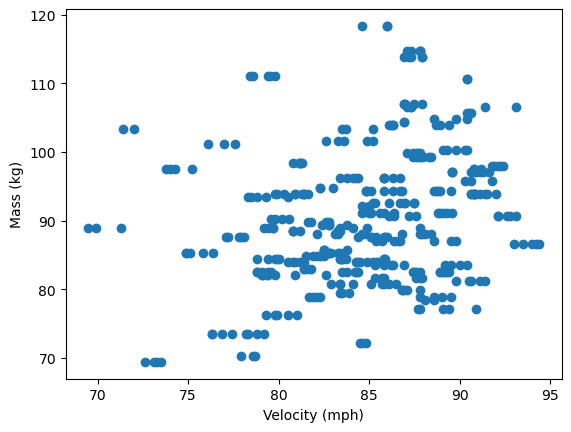

In [371]:
plt.scatter(encoded_data['pitch_speed_mph'], encoded_data['session_mass_kg'])
plt.xlabel('Velocity (mph)')
plt.ylabel('Mass (kg)')
plt.show()

In [331]:
X['max_shoulder_internal_rotational_velo'].describe()

count     403.000000
mean     4528.859826
std       316.214799
min      2717.636300
25%      4325.992100
50%      4525.994900
75%      4742.678300
max      5412.561400
Name: max_shoulder_internal_rotational_velo, dtype: float64

In [389]:
encoded_data['pitch_speed_mph'].corr(encoded_data['max_shoulder_internal_rotational_velo'])

0.32523584309172027

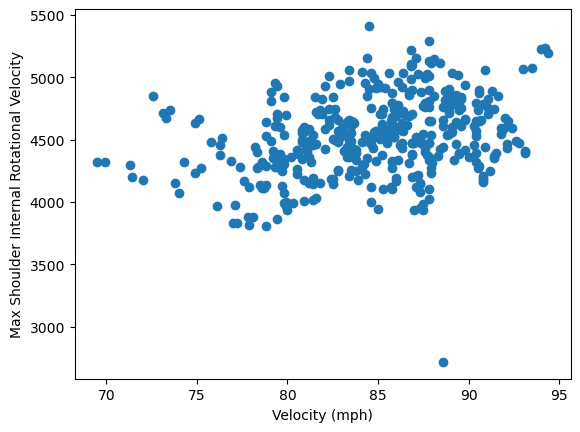

In [373]:
plt.scatter(encoded_data['pitch_speed_mph'], encoded_data['max_shoulder_internal_rotational_velo'])
plt.xlabel('Velocity (mph)')
plt.ylabel('Max Shoulder Internal Rotational Velocity')
plt.show()

In [335]:
X['max_elbow_extension_velo'].describe()

count     403.000000
mean     2464.204508
std       237.756567
min      1771.588000
25%      2308.355200
50%      2445.817700
75%      2608.412150
max      3100.266100
Name: max_elbow_extension_velo, dtype: float64

In [391]:
encoded_data['pitch_speed_mph'].corr(encoded_data['max_elbow_extension_velo'])

0.12532657241573653

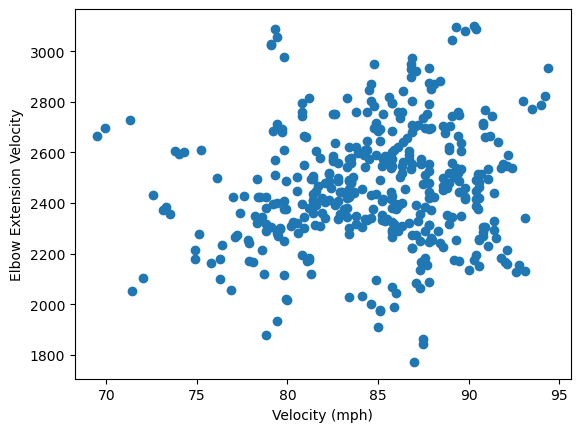

In [375]:
plt.scatter(encoded_data['pitch_speed_mph'], encoded_data['max_elbow_extension_velo'])
plt.xlabel('Velocity (mph)')
plt.ylabel('Elbow Extension Velocity')
plt.show()

In [337]:
X['max_torso_rotational_velo'].describe()

count     403.000000
mean     1055.827595
std        88.135226
min       848.383600
25%       999.429050
50%      1049.861900
75%      1110.417300
max      1383.236700
Name: max_torso_rotational_velo, dtype: float64

In [393]:
encoded_data['pitch_speed_mph'].corr(encoded_data['max_torso_rotational_velo'])

0.3200790779837214

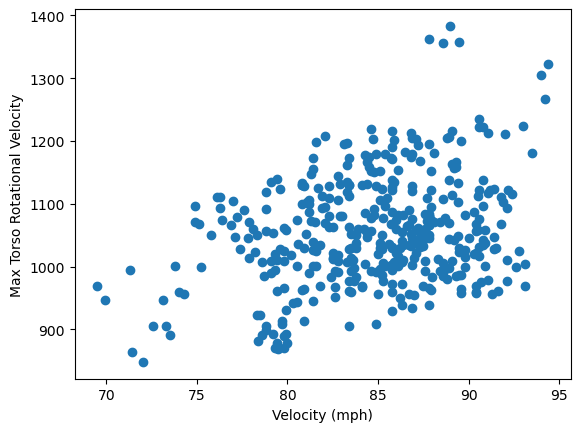

In [377]:
plt.scatter(encoded_data['pitch_speed_mph'], encoded_data['max_torso_rotational_velo'])
plt.xlabel('Velocity (mph)')
plt.ylabel('Max Torso Rotational Velocity')
plt.show()

# Model Selection

After looking at the model performance of both models, in regard to performance on testing and training data, I'm going to delve further into the XGBoost model. Given that XGBoost is a non-linear model it makes sense that the correlation with the most influential features is lower correlations. XGBoost can examine interactions between features, that may not be clearly displayed by just looking at metrics like correlation. In this next section, I will be engaging in some feature selection, followed by hyperparameter tuning of the model. 

After evaluating feature importance, I decided to drop columns from the dataset that had an F-score that was less than 10% of the F-score of the most influential feature.

* Note: In this notebook I dropped the column of 'playing_level_college', but in the production code, I have entirely removed the 'playing_level' column. I made this decision because this project is focused on the effectiveness of moving ones body and by including level of play, so this level can be noise to the model.

In [238]:
drop_cols = ['playing_level_college', 'torso_anterior_tilt_br',
             'rear_grf_z_max', 'pelvis_rotation_fp', 'rear_grf_x_max']

X_train = X_train.drop(drop_cols, axis = 1)

X_test = X_test.drop(drop_cols, axis = 1)

# Hyperparameter Tuning

In [247]:
## round 1
xgb1 = XGBRegressor()

params = {"n_estimators": range(0,500, 100),
          "learning_rate" : [0.001, 0.01, 0.1, 0.5],
          "max_depth" : range(2, 10),
          "reg_alpha" : [0, 1],
          "reg_lambda": [0,1],
          "objective": ["reg:squarederror"]}

gs_xgb = GridSearchCV(estimator = xgb1, param_grid = params,
                      scoring = 'neg_mean_absolute_error', cv = 5, n_jobs =-1)

gs_xgb.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 0.5],
                         'max_depth': range(2, 10),
                         'n_estimators': range(0, 500, 100),
                         'objective': ['reg:squarederror'], 'reg_alpha': [0, 1],
                         'reg_lambda': [0, 1]},
             scoring='neg_mean_absolute_error')

In [248]:
gs_xgb.best_params_, gs_xgb.best_score_

({'learning_rate': 0.1,
  'max_depth': 3,
  'n_estimators': 300,
  'objective': 'reg:squarederror',
  'reg_alpha': 1,
  'reg_lambda': 1},
 -1.2818291759075726)

In [271]:
model = XGBRegressor(**gs_xgb.best_params_)
model.fit(X_train, y_train)
pred1 = model.predict(X_test)

print("R-Squared Score:", r2_score(y_test, pred1))
print("MAE Score:", mean_absolute_error(y_test, pred1))
print("MSE Score:", mean_squared_error(y_test, pred1))

R-Squared Score: 0.8845658788383509
MAE Score: 1.150787718866913
MSE Score: 2.310358233106402


### Round 2

In [261]:
## hyperparameter tuning
model = XGBRegressor()

params = {"n_estimators": range(0,500, 50),
          "learning_rate" : [0.1, 0.5], 
          "max_depth" : range(3, 10),
          "reg_alpha" : range(0, 3),
          "reg_lambda": range(0, 3),
          "objective": ["reg:squarederror"]}

xgb2 = GridSearchCV(estimator = model, param_grid = params,
                      scoring = 'neg_mean_absolute_error', cv = 5, n_jobs = -1)

xgb2.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.5], 'max_depth': range(3, 10),
                         'n_estimators': range(0, 500, 50),
                         'objective': ['reg:squarederror'],
                         'reg_alpha': range(0, 3), 'reg_lambda': range(0, 3)},
             scoring='neg_mean_absolute_error')

In [262]:
xgb2.best_params_, xgb2.best_score_

({'learning_rate': 0.1,
  'max_depth': 3,
  'n_estimators': 450,
  'objective': 'reg:squarederror',
  'reg_alpha': 0,
  'reg_lambda': 2},
 -1.2667843211579564)

In [267]:
model = XGBRegressor(**xgb2.best_params_)
model.fit(X_train, y_train)
y_pred_XGB1 = model.predict(X_test)

print("R-Squared Score:", r2_score(y_test, y_pred_XGB1))
print("MAE Score:", mean_absolute_error(y_test, y_pred_XGB1))
print("MSE Score:", mean_squared_error(y_test, y_pred_XGB1))

R-Squared Score: 0.8859774051690361
MAE Score: 1.1319047095070427
MSE Score: 2.2821072147200945


Considering the MAE of the hyperparameter tuned model is 1.132 mph, which is about 1.3% of the average value in the dataset, I believe that the model is performing well and at the risk of overfitting this is the final model.

# Feature Importance of the Hyperparameter Tuned Model

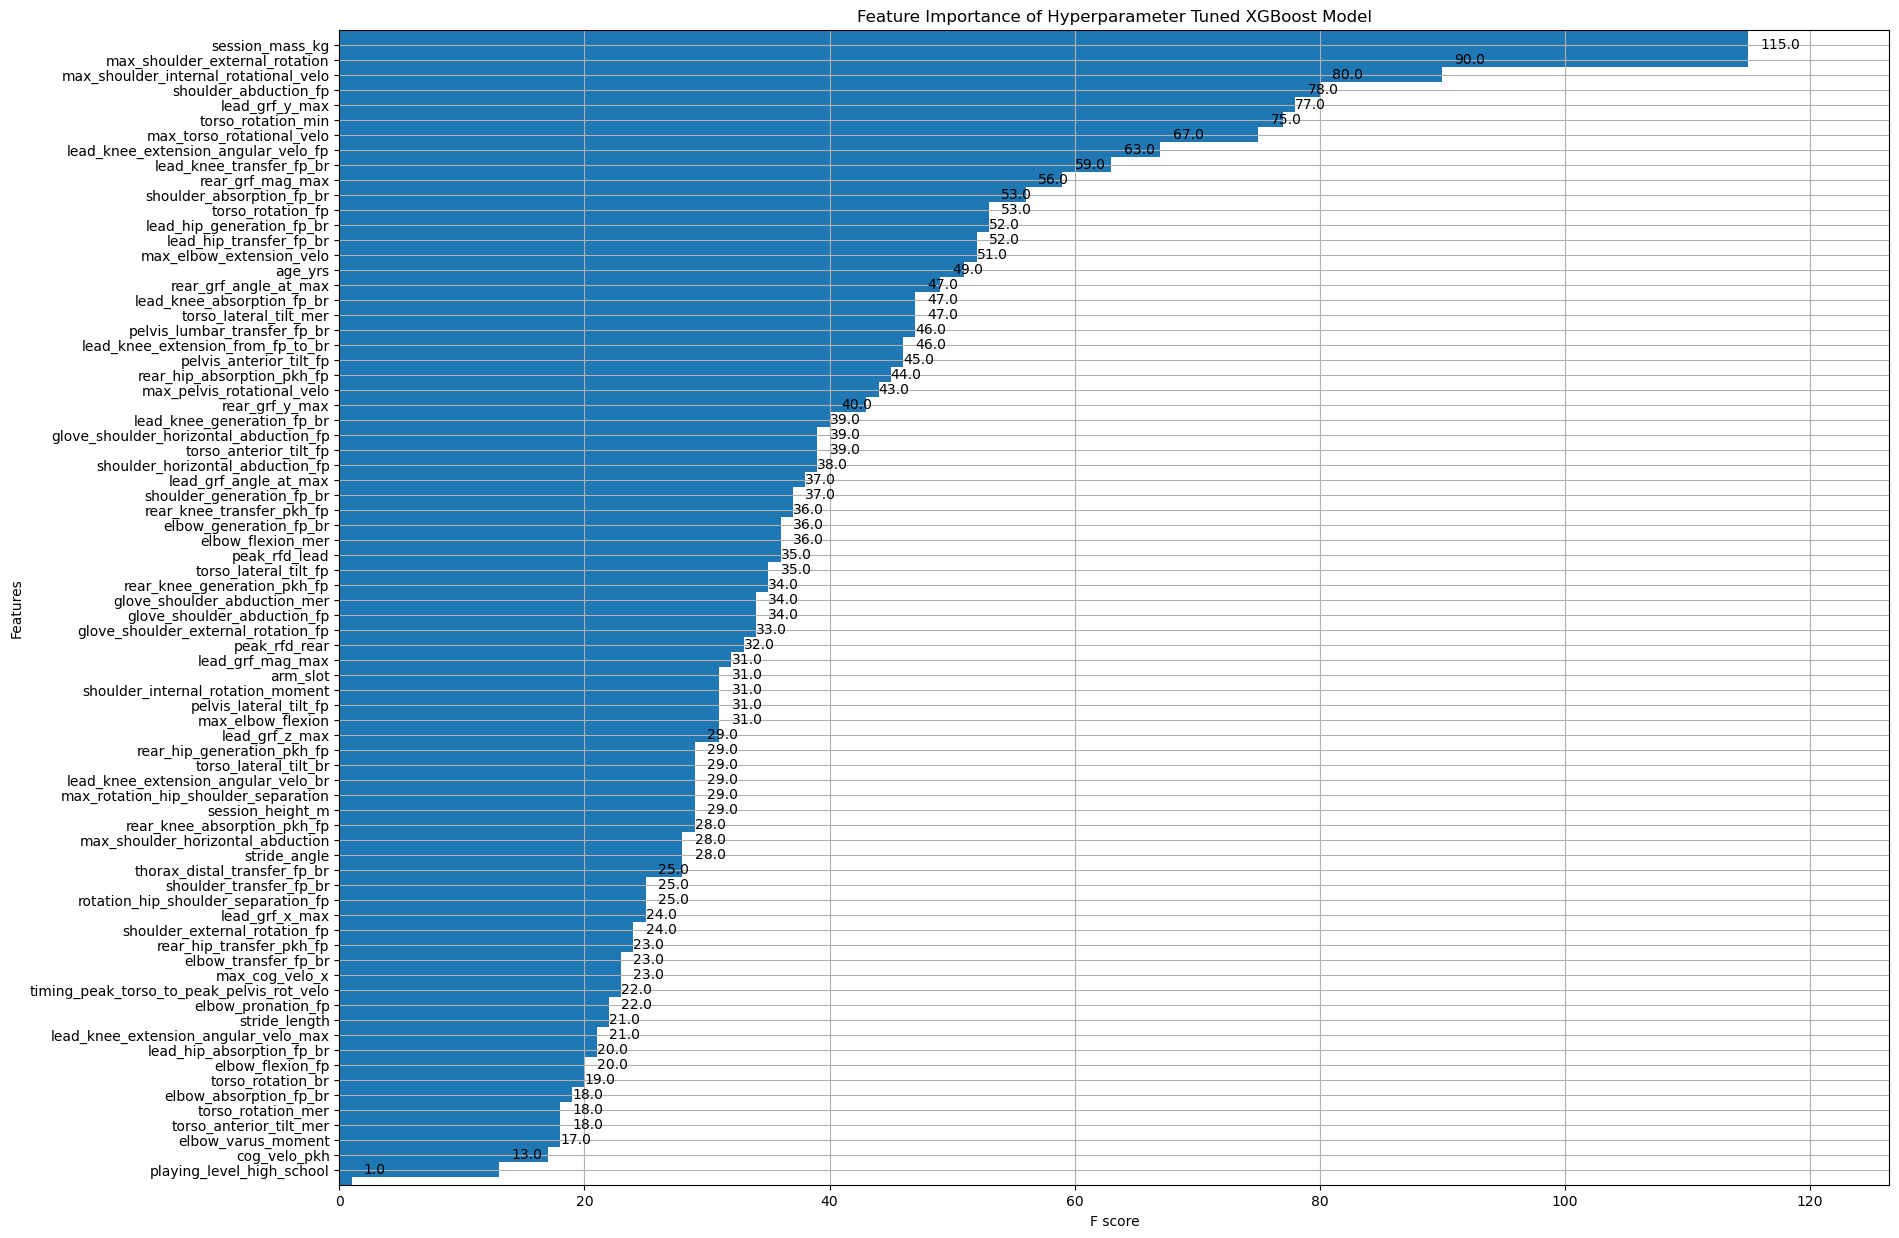

In [269]:
model1 = XGBRegressor(**xgb2.best_params_)
model1.fit(X_train, y_train)
fig, ax = plt.subplots(ncols = 1, figsize = (20,15))

plot_importance(model1, height = 3, ax = ax, title = 'Feature Importance of Hyperparameter Tuned XGBoost Model')
plt.show()

# Hyperparameter Tuned Feature Importance

After hyperparameter tuning the model I found two new variables moved up in regard to their influence, maximum shoulder external rotation and shoulder abduction. Shoulder abduction and external rotation go hand in hand. 

### Max Shoulder External Rotation
During shoulder external rotation, the pitcher is storing up elastic energy within the shoulder that helps them create the whipping motion during the pitch. This motion allows the arm to accelerate during internal rotation allowing for greater force to be imparted on the ball at release. I believe the model is placing importance on this because without effectively externally rotating the shoulder, this limits the arm speed a pitcher can generate.

### Shoulder Abduction
Shoulder abduction at footplant allows the pitcher to place their arm in a more optimal angle for external rotation, which is needed for effective energy transfer from the lower body through the arm. I believe the model places more importance on shoulder abduction because it directly impact shoulder external rotation, and shoulder internal rotation velocity (feature #3).

If you read this entire thing I really appreciate it and welcome any feedback or advice you may have!